## Problem Definition

* What is an LNA?

    LNA stands for Low-Noise Amplifier. It is an electronic component that amplifies a very weak signal (especially in radio and wireless communication systems) while introducing the minimum possible amount of additional electronic noise. The primary goal of an LNA is to boost the signal's power without significantly degrading its Signal-to-Noise Ratio (SNR).

* What is Noise Figure?

    Noise figure (NF) is a key metric in electronics, especially in radio frequency (RF) and wireless communication systems, that quantifies how much a device degrades the Signal-to-Noise Ratio (SNR) of a signal as it passes through. The noise factor $(F)$ is the linear ratio of the input SNR to the output SNR, $$F = \frac{(S_i / N_i)}{(S_o / N_o)}$$ Where, $S_i / N_i$ is the Signal-to-Noise Ratio at the input and $S_o / N_o$ is the Signal-to-Noise Ratio at the output. The Noise Figure (NF), expressed in decibels (dB), is calculated as:$$NF = 10 \cdot \log_{10}(F)$$

* Why 2.45 GHz?

    The 2.45 GHz frequency is used for Low-Noise Amplifiers (LNAs) because it is the center frequency of the 2.4 GHz Industrial, Scientific, and Medical (ISM) radio band (2.400 to 2.4835 GHz).

In [1]:
# Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

plt.rcParams['figure.figsize'] = (10, 5)

## Simulation Plan

* Generate a frequency range around 2.45 GHz
* Model a simple LNA gain response
* Model a simple noise figure curve
* Combine them into a basic LNA model
* Automate NF calculations across the band
* Visualize results (gain plot, NF plot)
* Summarize metrics

## Assumptions

* Idealized LNA model for demonstration
* Smooth gain response, not real S-parameters
* Noise figure modeled with simple mathematical functions
* Focus is automation and visualization, not hardware accuracy

## Frequency Axis

We generate a frequency array centered at 2.45 GHz with a 50 MHz span. This will be used for all gain and noise figure calculations.

In [2]:
# Frequency parameters
fc = 2.45e9        # Center frequency 2.45 GHz
span = 50e6        # 50 MHz
num_points = 1001  # high resolution

# Frequency array
freq = np.linspace(fc - span, fc + span, num_points)

freq[:10], freq[-10:] # preview first and last values

(array([2.4000e+09, 2.4001e+09, 2.4002e+09, 2.4003e+09, 2.4004e+09,
        2.4005e+09, 2.4006e+09, 2.4007e+09, 2.4008e+09, 2.4009e+09]),
 array([2.4991e+09, 2.4992e+09, 2.4993e+09, 2.4994e+09, 2.4995e+09,
        2.4996e+09, 2.4997e+09, 2.4998e+09, 2.4999e+09, 2.5000e+09]))

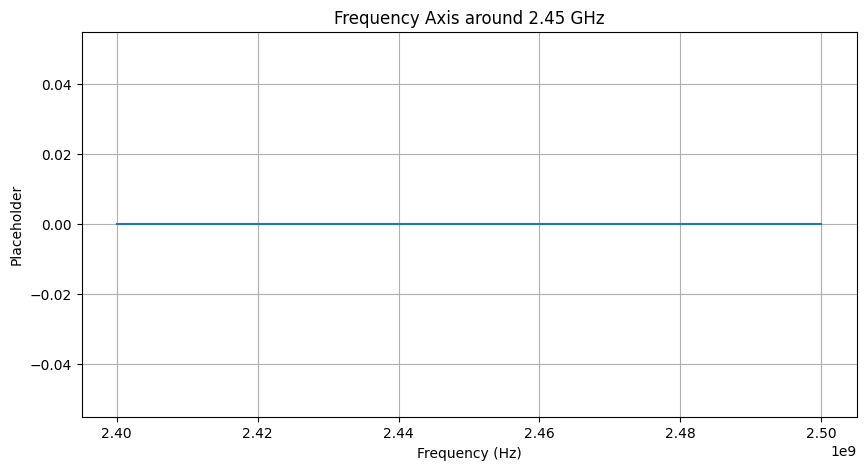

In [3]:
plt.plot(freq, np.zeros_like(freq));
plt.title("Frequency Axis around 2.45 GHz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Placeholder")
plt.grid(True)

### Notes

* Frequency range: 2.40-2.50 GHz
* Resolution: ~100 kHz
* This array will be reused for gain and NF models

### LNA Gain Model

Creating a Gaussian-shaped gain curve peaking near 2.45 GHz (approximately 20 dB peak) and plot it in dB vs frequency in GHz.

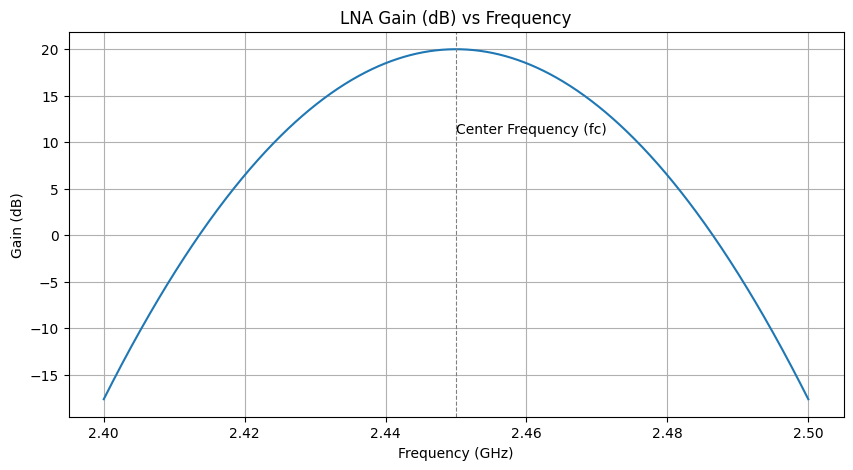

In [4]:
# LNA Gain Model

# Parameters
peak_gain_db = 20
fwhm = 40e6             # Full Width Half Maximum ~ 40 Hz (adjustable)

# converting dB to linear voltage gain (dB referenced to voltage => 20*log10)
peak_gain_lin = 10**(peak_gain_db / 20)

# Gaussian sigma from FWHM: FWHM = 2*sqrt(*ln2)*sigma
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))

# Building a Gaussian-shaped linear gain, then converting to dB
gain_lin = peak_gain_lin * np.exp(-0.5 * ((freq - fc) / sigma)**2)
gain_db = 20 * np.log10(gain_lin)    # converting linear voltage gain to dB

# clamp extremely low values to avoid -inf from log
gain_db = np.clip(gain_db, -60, 100)  # The np.clip function acts as a safety measure. Because the logarithm of a number close to zero 
                                      # can result in negative infinity ($\text{-}\infty$), this line ensures the lowest possible gain is 
                                      # capped at $-60$ dB to prevent plotting errors.

# Plot (frequency in GHz)
plt.plot(freq / 1e9, gain_db)
plt.title("LNA Gain (dB) vs Frequency")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Gain (dB)")
plt.grid(True)

plt.axvline(fc / 1e9, color='gray', linestyle='--', linewidth=0.8) # draws a dashed line at fc and labels it to show where the peak gain occurs.
plt.text(fc / 1e9, peak_gain_db - 9, 'Center Frequency (fc)');

### Noise Figure (NF) Model

We model NF as a small-band variation around a low baseline (e.g., 0.8-2.5 dB). Convert NF (dB) into noise factor and then equivalent noise temperature (Te) using T0 = 290K for later use.

NF at center (2.450 GHz): 1.200 dB
Average NF across band: 1.291 dB
Min NF: 1.200 dB, Max NF: 1.455 dB


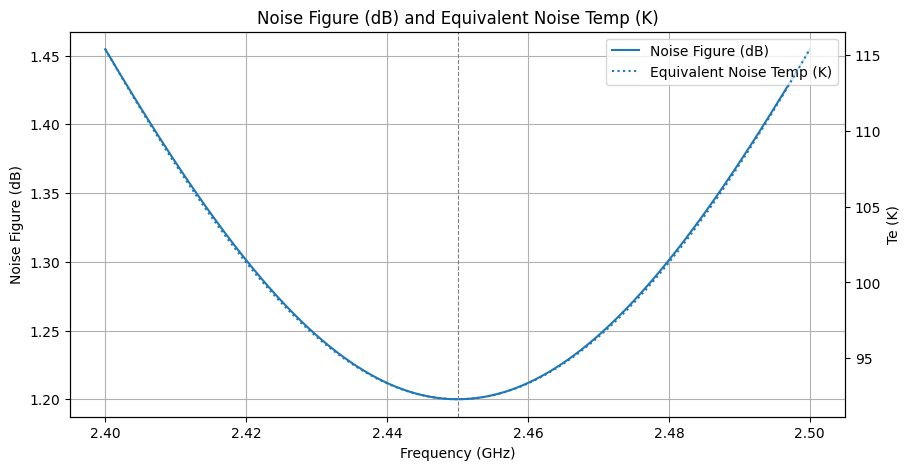

In [5]:
# Noise Figure model

# Noise figure parameters (dB)
nf_center_db = 1.2     # baseline noise figure at center (dB)
nf_ripple_db = 0.8     # peak deviation around center (dB)
nf_rolloff = 60e6      # controls how quickly NF rises off-center

# Building a gentle U-shaped NF curve (combination of Gaussian + quadratic)
nf_db = nf_center_db + nf_ripple_db * (1 - np.exp(-0.5 * ((freq - fc) / nf_rolloff)**2))

# adding a small quadratic trend to make edges slightly worse
nf_db += 0.02 * ((freq - fc) / (span))**2

# Clip to sensible bounds (avoid nonsense)
nf_db = np.clip(nf_db, 0.3, 10)

# converting NF dB into noise factor (linear) and to equivalent noise temperature Te (K)
T0 = 290
nf_lin = 10**(nf_db / 10)
te_k = (nf_lin - 1) * T0

# Plot NF (dB) and Te (K) with twin axis
fig, ax1 =  plt.subplots()
ax1.plot(freq / 1e9, nf_db, label='Noise Figure (dB)')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Noise Figure (dB)')
ax1.grid(True)
ax1.axvline(fc / 1e9, color='gray', linestyle='--', linewidth=0.8)

ax2 = ax1.twinx()
ax2.plot(freq / 1e9, te_k, linestyle=':', label='Equivalent Noise Temp (K)')
ax2.set_ylabel('Te (K)')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Noise Figure (dB) and Equivalent Noise Temp (K)');

# Quick summary values
print(f"NF at center ({fc / 1e9:.3f} GHz): {np.interp(fc, freq, nf_db):.3f} dB")
print(f"Average NF across band: {np.mean(nf_db):.3f} dB")
print(f"Min NF: {np.min(nf_db):.3f} dB, Max NF: {np.max(nf_db):.3f} dB")

### LNA Model Function

Building an lna_model function that returns gain (dB and linear), noise figure (dB and linear), equivalent noise temp, and a small summary dict.

In [6]:
# LNA model function

def lna_model(freq,
              fc,
              peak_gain_db = 20,
              gain_fwhm = 40e6,
              nf_center_db = 1.2,
              nf_ripple_db = 0.8,
              nf_rolloff = 60e6):
    """
    Returns a dictionary with LNA model outputs computed over 'freq'.

    Outputs (numpy arrays):
    - gain_db: voltage-gain in dB (20*log10 of voltage gain)
    - gain_lin_v: linear voltage gain (useful for some models)
    - gain_lin_p: linear power gain (10^(gain_db/10))
    - nf_db: noise figure in dB
    - nf_lin: noise factor (linear)
    - te_k: equivalent noise temperature (Kelvin)

    and a summary dict with center/average/min/max values.
    """

    # gain
    peak_gain_lin_v = 10**(peak_gain_db / 20)
    sigma = gain_fwhm / (2 * np.sqrt(2 * np.log(2)))
    gain_lin_v = peak_gain_lin_v * np.exp(-0.5 * ((freq - fc) / sigma)**2)

    # convert to dB and also provide power gain
    gain_db = 20 * np.log10(gain_lin_v)
    gain_db = np.clip(gain_db, -60, 100)
    gain_lin_p = 10**(gain_db / 10) # power gain (linear)

    # noise figure
    nf_db_calc = nf_center_db + nf_ripple_db * (1 - np.exp(-0.5 * ((freq - fc) / nf_rolloff)**2))
    nf_db_calc += 0.02 * ((freq - fc) / (span))**2
    nf_db_calc = np.clip(nf_db_calc, 0.01, 30)  # keep sensible bounds
    nf_lin = 10**(nf_db_calc / 10)
    T0 = 290
    te_k = (nf_lin - 1) * T0

    # summary
    summary = {
        'center_freq_hz':  fc,
        'gain_db_center': float(np.interp(fc, freq, gain_db)),
        'gain_db_avg': float(np.mean(gain_db)),
        'nf_db_center': float(np.interp(fc, freq, nf_db_calc)),
        'nf_db_avg': float(np.mean(nf_db_calc)),
        'te_k_center': float(np.interp(fc, freq, te_k))
    }

    return {
        'freq': freq,
        'gain_db': gain_db,
        'gain_lin_v': gain_lin_v,
        'gain_lin_p': gain_lin_p,
        'nf_db': nf_db_calc,
        'nf_lin': nf_lin,
        'te_k': te_k,
        'summary': summary
    }

# Example usage and quick printout
model = lna_model(freq, fc)

print(" __LNA Model Summary__ ")
print(f"Center freq: {model['summary']['center_freq_hz']/1e9:.6f} GHz")
print(f"Gain at center: {model['summary']['gain_db_center']:.3f} dB (avg {model['summary']['gain_db_avg']:.3f} dB)")
print(f"NF at center: {model['summary']['nf_db_center']:.3f} dB (avg {model['summary']['nf_db_avg']:.3f} dB)")
print(f"Te at center: {model['summary']['te_k_center']:.1f} K")

 __LNA Model Summary__ 
Center freq: 2.450000 GHz
Gain at center: 20.000 dB (avg 7.432 dB)
NF at center: 1.200 dB (avg 1.291 dB)
Te at center: 92.3 K


## Results and Plots

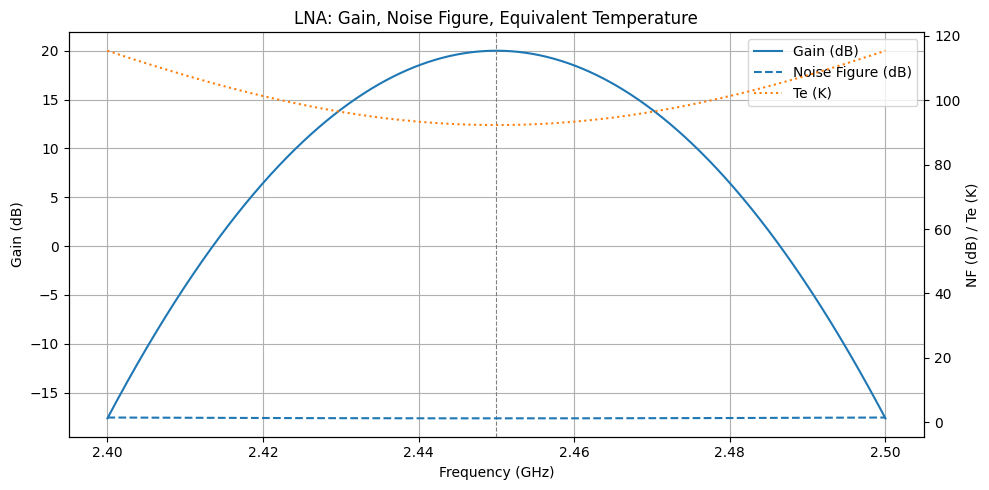

Saved combined figure to: figures\combined_gain_nf_te.png
Individual plots saved!


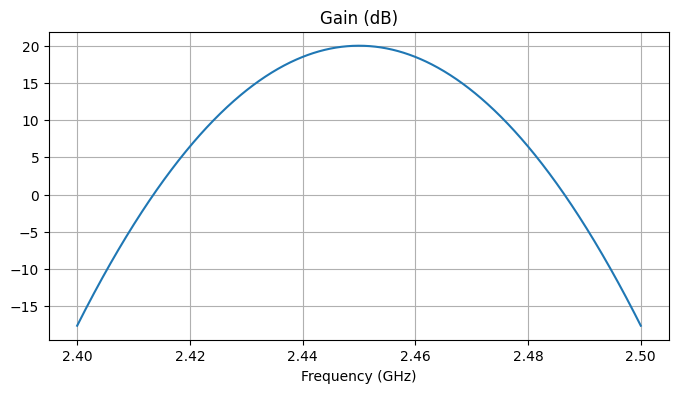

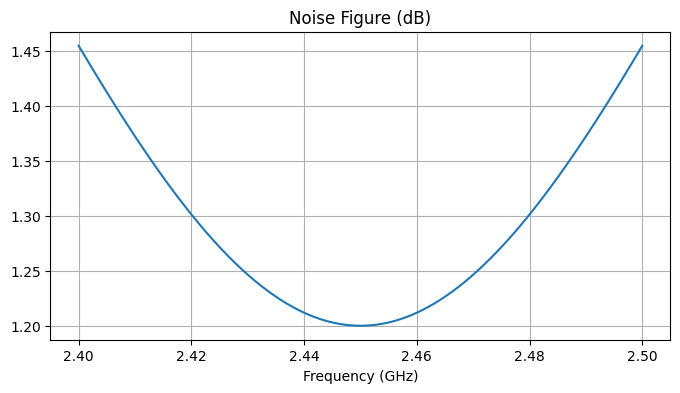

In [7]:
# Combined results plot and export

import os
fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

# Data
fghz = model['freq'] / 1e9
gain_db = model['gain_db']
nf_db = model['nf_db']
te_k = model['te_k']

# Combined plot: gain (left y), NF and Te (right y)
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(fghz, gain_db, label='Gain (dB)')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('Gain (dB)')
ax1.grid(True)
ax1.axvline(fc/1e9, color='gray', linestyle='--', linewidth=0.8)

ax2 = ax1.twinx()
ax2.plot(fghz, nf_db, linestyle='--', label='Noise Figure (dB)')
ax2.plot(fghz, te_k, linestyle=':', label='Te (K)')
ax2.set_ylabel('NF (dB) / Te (K)')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('LNA: Gain, Noise Figure, Equivalent Temperature')
plt.tight_layout()

# Save
png_path = os.path.join(fig_dir, 'combined_gain_nf_te.png')
fig.savefig(png_path, dpi=200)
plt.show()
print(f"Saved combined figure to: {png_path}")

# Also save individual plots
fig2, ax = plt.subplots(figsize=(8, 4))
ax.plot(fghz, gain_db); ax.set_title('Gain (dB)'); ax.set_xlabel('Frequency (GHz)'); ax.grid(True)
fig2.savefig(os.path.join(fig_dir, 'gain_db.png'), dpi=200)

fig3, ax = plt.subplots(figsize=(8, 4))
ax.plot(fghz, nf_db); ax.set_title('Noise Figure (dB)'); ax.set_xlabel('Frequency (GHz)'); ax.grid(True)
fig3.savefig(os.path.join(fig_dir, 'noise_figure_db.png'), dpi=200)

print('Individual plots saved!')

## Parameter Sweep Automation

We sweep different gain and noise figure configurations and log the results automatically.

In [8]:
import csv
import os

def simulate_lna(center_gain_db, nf_center_db, case_name):
    """
    Runs gain + NF + Te simulation and exports:
    - combined plot
    - summary dictionary
    """

    # Gain model
    gain_sigma = span / 15
    gain_db = center_gain_db * np.exp(-0.5 * ((freq - fc) / gain_sigma)**2)
    gain_db += 2 * ((freq - fc) / (span / 2))**2
    gain_db = np.clip(gain_db, -10, None)

    # Noise Figure Model
    nf_ripple_db = 0.1
    nf_rolloff = 80e6
    nf_db = nf_center_db + nf_ripple_db * (1 - np.exp(-0.5 * ((freq - fc) / nf_rolloff)**2))
    nf_db += 0.02 * ((freq - fc) / span)**2
    nf_db = np.clip(nf_db, 0.3, 10)

    nf_lin = 10**(nf_db / 10)
    Te = (nf_lin -1) * 290

    # Plot Export
    fig, ax1 = plt.subplots()
    ax1.plot(freq / 1e9, gain_db, label="Gain (dB)")
    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('Gain (dB)')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(freq / 1e9, nf_db, color='orange', label='Nf (dB)')
    ax2.set_ylabel('NF (dB)')

    fig.suptitle(f"LNA Simulation - {case_name}")

    # Save
    os.makedirs("figures/sweeps", exist_ok=True)
    fig.savefig(f"figures/sweeps/{case_name}.png", dpi=300)
    plt.close(fig)

    # Summary
    summary = {
        'case': case_name,
        'center_gain_db': center_gain_db,
        'center_nf_db': nf_center_db,
        'avg_gain_db': float(np.mean(gain_db)),
        'avg_nf_db': float(np.mean(nf_db)),
        'te_center_K': float(np.interp(fc, freq, Te))
    }

    return summary
    

In [9]:
# Sweeping multiple parameter combinations
sweep_cases = [
    {'gain': 18, 'nf': 1.1, 'name': 'case_18dB_1.1NF'},
    {'gain': 20, 'nf': 1.2, 'name': 'case_20dB_1.2NF'},
    {'gain': 22, 'nf': 1.4, 'name': 'case_22dB_1.4NF'}
]

results = []

for c in sweep_cases:
    summary = simulate_lna(c['gain'], c['nf'], c['name'])
    results.append(summary)

results

[{'case': 'case_18dB_1.1NF',
  'center_gain_db': 18,
  'center_nf_db': 1.1,
  'avg_gain_db': 4.174474490288312,
  'avg_nf_db': 1.1128376289959157,
  'te_center_K': 83.59236999100887},
 {'case': 'case_20dB_1.2NF',
  'center_gain_db': 20,
  'center_nf_db': 1.2,
  'avg_gain_db': 4.341416100320347,
  'avg_nf_db': 1.2128376289959155,
  'te_center_K': 92.29445418135803},
 {'case': 'case_22dB_1.4NF',
  'center_gain_db': 22,
  'center_nf_db': 1.4,
  'avg_gain_db': 4.508357710352382,
  'avg_nf_db': 1.4128376289959155,
  'te_center_K': 110.31143673483658}]

In [10]:
# Exporting results to a CSV file
csv_path = 'figures/sweeps/summary.csv'

with open(csv_path, 'w', newline="") as f:
    writer = csv.DictWriter(f, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print('Saved:', csv_path)

Saved: figures/sweeps/summary.csv


## S21-like gain model (2nd order bandpass) and comparison

Implementing a second-order resonant bandpass magnitude to mimic realistic S21 behaviour (control with Q). Plot it vs the Gaussian gain used earlier and save the comparison.

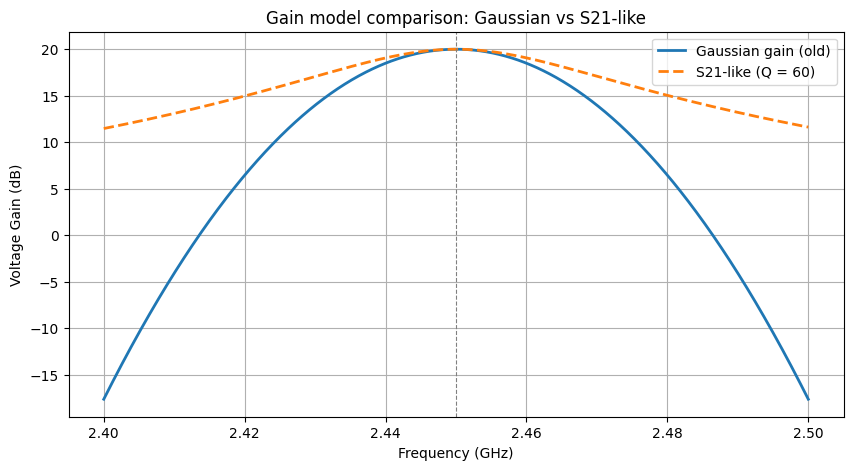

Saved comparison figure to: figures/sweeps/gain_model_comparison.png
Gaussian gain at center: 20.000 dB
S21-like gain at center; 20.000 dB
Approx. 3 dB bandwidth (s21-like): 40.60  MHz (Q = 60)


In [11]:
# Parameters for the S21-like model
f0 = fc       # resonant centre (Hz)
Q = 60                  # quality factor (adjustable: higher is narrower)
peak_gain_db_s21 = 20   # peak voltage gain in dB for S21 model

# Angular frequencies
w = 2 * np.pi * freq
w0 = 2 * np.pi * f0

# 2nd-order bandpass magnitude (voltage form)
H_mag = (w / w0) / np.sqrt((1 - (w / w0)**2)**2 + (w / (Q * w0))**2)

# Normalize and scale to desired peak gain (voltage)
H_mag /= np.max(H_mag)    # normalizing so that peak = 1
H_mag_v = H_mag * (10 **(peak_gain_db_s21 / 20))  # scaling to peak voltage linear
gain_db_s21 = 20 * np.log10(H_mag_v)
gain_db_s21 = np.clip(gain_db_s21, -80, 100)  # clamping for plotting safety

# Creating comaparison figure (gaussian vs S21)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq / 1e9, gain_db, label='Gaussian gain (old)', linewidth=2)
ax.plot(freq / 1e9, gain_db_s21, label=f'S21-like (Q = {Q})', linewidth=2, linestyle = '--')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Voltage Gain (dB)')
ax.set_title('Gain model comparison: Gaussian vs S21-like')
ax.grid(True)
ax.axvline(fc / 1e9, color='gray', linestyle='--', linewidth=0.8)
ax.legend(loc='upper right')

# Save figure
os.makedirs("figures/sweeps", exist_ok=True)
comp_path = 'figures/sweeps/gain_model_comparison.png'
fig.savefig(comp_path, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved comparison figure to: {comp_path}')

# Quick numeric checks printed
center_gauss = float(np.interp(fc, freq, gain_db))
center_s21 = float(np.interp(fc, freq, gain_db_s21))
bw_3db_idx = np.where(gain_db_s21 >= (center_s21 - 3))[0]

if bw_3db_idx.size:
    bw_3db_hz = freq[bw_3db_idx[-1]] - freq[bw_3db_idx[0]]
else:
    bw_3db_hz = np.nan

print(f'Gaussian gain at center: {center_gauss:.3f} dB')
print(f'S21-like gain at center; {center_s21:.3f} dB')
print(f'Approx. 3 dB bandwidth (s21-like): {bw_3db_hz / 1e6:.2f}  MHz (Q = {Q})')

## Unified run_lna_simulation() + automated tasks

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

def run_lna_simulation(center_gain_db, center_nf_db, Q, case_name,
                       model='s21', save=True):

    """
    Unified LNA simulation:
    - Gain model: Gaussian or S21-like
    - Noise Figure and Noise Temperature
    - Plots: Gain and Noise Figure
    - Returns summary dict with key metrics
    """

    # Gain model (selectable)

    if model.lower() == 'gaussian':
        span = np.max(freq) - np.min(freq)
        gain_sigma = span / 15
        gain_db = center_gain_db * np.exp(-0.5 * ((freq - fc) / gain_sigma) ** 2)
        gain_db += 2 * ((freq - fc) / (span / 2)) ** 2
        gain_db = np.clip(gain_db, -20, None)

    elif model.lower() == 's21':
        # 2nd-order bandpass S21 simulation
        w = 2 * np.pi * freq
        w0 = 2 * np.pi * fc

        Hmag = (w / w0) / np.sqrt((1 - (w / w0)**2)**2 + (w / (Q * w0)) **2)
        Hmag /= np.max(Hmag)
        H_v = Hmag * (10 ** (center_gain_db / 20))
        gain_db = 20 * np.log10(H_v)
        gain_db = np.clip(gain_db, -80, 100)

    else:
        raise ValueError("model must be 'gaussian' or 'S21'")


    # Noise Figure model

    nf_ripple_db = 0.1
    nf_rolloff = 80e6

    nf_db = center_nf_db + nf_ripple_db * (1 - np.exp(-0.5 * ((freq - fc) / nf_rolloff)**2))
    nf_db += 0.02 * ((freq - fc) / (freq[-1]-freq[0]))**2
    nf_db = np.clip(nf_db, 0.3, 10)

    nf_lin = 10 ** (nf_db / 10)
    Te = (nf_lin - 1) * 290

    # Extract Metrics

    gain_center = float(np.interp(fc, freq, gain_db))
    gain_avg = float(np.mean(gain_db))

    nf_center = float(np.interp(fc, freq, nf_db))
    nf_avg = float(np.mean(nf_db))

    te_center = float(np.interp(fc, freq, Te))

    # 3 dB bandwidth (for S21)
    if model == 's21':
        idx = np.where(gain_db >= gain_center - 3)[0]
        if idx.size:
            bw = freq[idx[-1]] - freq[idx[0]]
        else:
            bw = np.nan
    else:
        bw = np.nan

    # Plot export

    if save:
        os.makedirs('figures/unified', exist_ok=True)
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(freq / 1e9, gain_db, label='Gain', linewidth=2)
        ax1.set_xlabel('Frequency (GHz)')
        ax1.set_ylabel('Gain (dB)')
        ax1.grid(True)

        ax2 = ax1.twinx()
        ax2.plot(freq / 1e9, nf_db, label='NF', color='darkorange')
        ax2.set_ylabel("Noise Figure (dB)")

        fig.suptitle(f"LNA Simulation - {case_name} ({model})")
        fig.savefig(f"figures/unified/{case_name}.png", dpi=200, bbox_inches='tight')
        plt.close(fig)


    # Return summary

    return {
        'case': case_name,
        'model': model,
        'center_gain_db': gain_center,
        'avg_gain_db': gain_avg,
        'center_nf_db': nf_center,
        'avg_nf_db': nf_avg,
        'te_center_K': te_center,
        'bw_3db_Hz': bw
    }
    

In [25]:
# Test
print("Running Unified run_lna_simulation() test...")

case1 = run_lna_simulation(20, 1.2, 60, 'test_gaussian', model='gaussian')
case2 = run_lna_simulation(20, 1.2, 60, 'test_s21', model='s21')

print(case1)
print(case2)

assert case1['center_gain_db'] > 0, 'Gaussian gain seems invalid'
assert case2['center_gain_db'] > 0, 'S21 gain seems invalid'
assert case1['center_nf_db'] >= 0.3, 'NF too low!'
assert case2['center_nf_db'] >= 0.3, 'NF too low!'

print("All Unified run_lna_simulation() tests passed")

Running Unified run_lna_simulation() test...
{'case': 'test_gaussian', 'model': 'gaussian', 'center_gain_db': 20.0, 'avg_gain_db': 4.006832200640492, 'center_nf_db': 1.2, 'avg_nf_db': 1.2078276289959156, 'te_center_K': 92.29445418135803, 'bw_3db_Hz': nan}
{'case': 'test_s21', 'model': 's21', 'center_gain_db': 20.0, 'avg_gain_db': 16.035342826006495, 'center_nf_db': 1.2, 'avg_nf_db': 1.2078276289959156, 'te_center_K': 92.29445418135803, 'bw_3db_Hz': np.float64(40600000.0)}
All Unified run_lna_simulation() tests passed
